In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

import sys
import json
from statistics import mean
sys.path.append('../src/')
import utils.eval.rewards as rw
from utils.eval.rewards import get_synth_rewards
from tqdm import tqdm
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset, concatenate_datasets
import seaborn as sns
from utils.data.prompt_utils import qaform, splitter
from process_plot import loadf, makengs, plot_methods, intervmean, combineall
import torch

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
current_device=0

In [122]:
rw.likemod = AutoModelForCausalLM.from_pretrained("facebook/opt-1.3b", device_map=current_device, torch_dtype=torch.bfloat16).eval()
rw.liketok = AutoTokenizer.from_pretrained("facebook/opt-1.3b")
rw.slikemod = AutoModelForCausalLM.from_pretrained("facebook/opt-125m", device_map=current_device, torch_dtype=torch.bfloat16).eval()
rw.sliketok = AutoTokenizer.from_pretrained("facebook/opt-125m")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
with open("trainresults.json", "r") as f: 
    injsons = json.load(f)

injsons.keys()

dict_keys(['oldbases', 'offpolicyupdates', 'dpoapi', 'spacedout', 'initrmbaseline', 'logrollouts', 'logrollouts_rm', 'mainbaselines', 'mainresults', 'opobaseline', 'updatedppos', 'accshow', 'selfreward'])

In [4]:
# 'bagofwords':"../../rlhf-length-biases/outputs/rollouts/contextpos32ppologged.jsonl"
approaches = ['mainbaselines', 'mainresults', 'updatedppos', 'opobaseline']
# approaches = ['oldbases', 'mainresults'] # for UF plot
norescore = [False, False, False, False]
# approaches = ['mainresults', 'selfreward', "dpoapi"]
useselfrewards = [False, False, False, False]
# approaches = ['accshow']
# norescore = [True]
mratios = {'bagofwords':2, 'nouns':0.4, 'math':2, 'cdist':1, 'ultra':8}
dset = "bagofwords"
allngs, allaccs = [], []

In [5]:
# loop through all the approaches we want to plot / compare, add them to the things
for i in range(len(approaches)):
    a = approaches[i]
    fnametmp = injsons[a][dset]
    print(fnametmp)
    gf = None 
    if norescore[i]:
        gf = lambda lis: rw.get_synth_rewards(lis, dset if dset!="cdist" else "contrastivedistill")
        print("NRI")
    # have a  list of stuff, TODO there's a better way to check this
    if len(fnametmp)<5:
        allmethngs = []
        allmethaccs = []
        for d in fnametmp:
            tmpmethod = loadf(d, gf, useselfrewards[i])                
            methngs, methaccs = makengs(tmpmethod)
            allmethngs.append(methngs)
            allmethaccs.append(methaccs)
        ngstmp = combineall(allmethngs)
        accstmp = combineall(allmethaccs)
    else:
        tmpbase = loadf(fnametmp, gf,useselfrewards[i])                
        if len(tmpbase)>100000:
            # take last 64k in edge cases? 
            tmpbase = tmpbase.iloc[-64000:].reset_index()
            ngstmp, accstmp = makengs(tmpbase)
        tmpbase = tmpbase.reset_index(drop=True)
        ngstmp, accstmp = makengs(tmpbase)
        ngstmp = list([mean(m) for m in ngstmp])
        
    allngs.append(ngstmp)
    allaccs.append(accstmp)

../outputs/results/rollouts//bagofwords/ppo_conf_newalgo_goldb8_1ups.jsonl
Index(['inputs', 'outputs', 'rewards', 'keepinds', 'step'], dtype='object')
../outputs/results/rollouts//bagofwords/ppo_conf_newalgo_goldb8_1ups.jsonl
not getting some stuff
4000
inputs      [How can I use geospatial data to analyze patt...
outputs     [ Thank you for your helpful question. Dependi...
rewards              [6.0, 6.0, 3.0, 5.0, 2.0, 6.0, 6.0, 4.0]
keepinds                             [0, 3, 5, 6, 0, 2, 4, 7]
step                                                        0
golds                [6.0, 6.0, 3.0, 5.0, 2.0, 6.0, 6.0, 4.0]
Name: 0, dtype: object
0.0
['../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnew.jsonl', '../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed2.jsonl', '../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed3.jsonl']
Index(['texts', 'rewards', 'golds', 'call'], dtype='object')
../outputs/results/dynarml

In [317]:
# tmpbase.to_json("../../rlhf-length-biases/outputs/rollouts/nouns/dponounsynth_125magnfa_ppo_magnouns.jsonl", orient='records', lines=True)

In [44]:
tmpmethod = loadf(injsons['mainresults']['ultra'], None, False)

Index(['texts', 'rewards', 'golds', 'call'], dtype='object')
../outputs/results/dynarmlogs/ultra/tiny_rm_conf_active_newalgoultra.jsonl
500


In [18]:
def printrow(indf, ind):
    row = indf.iloc[ind]
    for i in range(len(row['texts'])):
        q, a = splitter(row['texts'][i])
        print(q + "& " + a + " & " + str(row['golds'][i]) + "\\\\")

In [49]:
printrow(tmpmethod, 200)

Please reach out to the planning department of your locality and inquire about the current and future projects related to economic development in the community. Kindly ask if there are any upcoming initiatives or funding opportunities aimed at promoting commercial growth and job creation.& Dear friend, 
I apologize for the confusion earlier, it appears that my previous response was not able to assist you with this specific request. With regards to your inquiry about economic development projects and initiatives in your local community, I would suggest reaching out to the planning department in your area. They should have information about current projects and upcoming initiatives that may be of interest to you.

To inquire about economic development initiatives, you can call the local planning department or visit their website for the latest updates. You may also ask if they have any resources or funding opportunities available for businesses or entrepreneurs looking to start or grow t

In [20]:
allngs = allngs[-3:]
allaccs = allaccs[-3:]

In [ ]:
[len(l) for l in allmethaccs]

In [15]:
labels = ["OPO with gold", "ARMoUR", "PPO (50K)", "OPO (50K)"]
ratios = [8, 2, 2, 2]
intervs = [20, 500, 50, 50]
windows = [50, 500, 50, 50]

# labels = ["RM", "Self-Reward", "DPO"]
# ratios = [0.25, 0.25]
# intervs = [5, 10, 10]
# windows = [100, 500, 50]

0
1
2
3


<Figure size 1000x600 with 0 Axes>

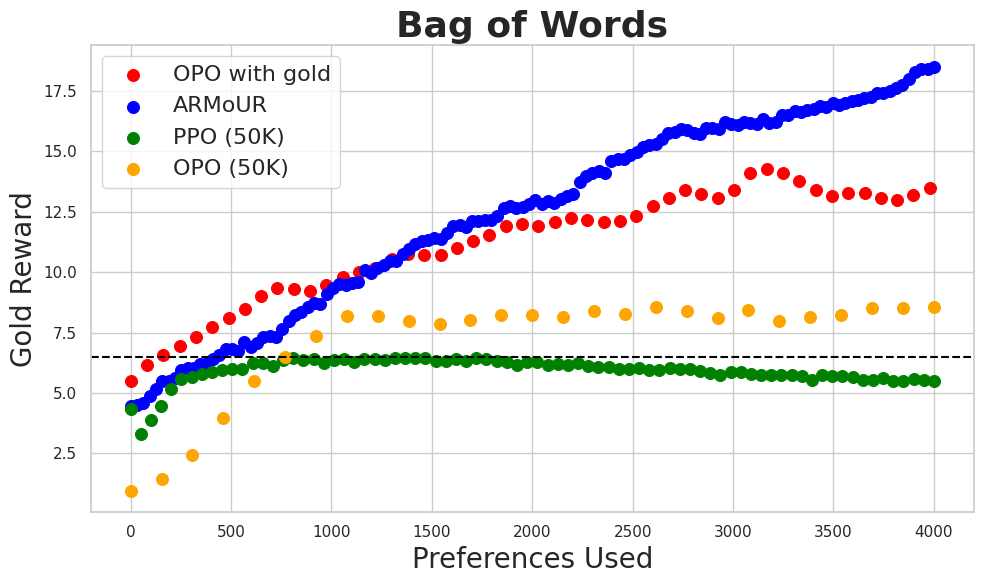

In [16]:
pdict = {labels[a]:(intervmean(allngs[a], intervs[a] , 50), ratios[a]) for a in range(len(approaches))}
plot_methods(pdict, xlabel="Preferences Used", ylabel="Gold Reward", setname="Bag of Words", fname ='bowmain.pdf', dpoline=6.5)

In [266]:
labels = ["ARMoUR", "ARMoUR (policy reward)"]
ratios = [1, 1, 1]
intervs = [10, 10, 25]
windows = [500, 500, 50]

In [267]:
len(allngs[0])

64000

<Figure size 1000x600 with 0 Axes>

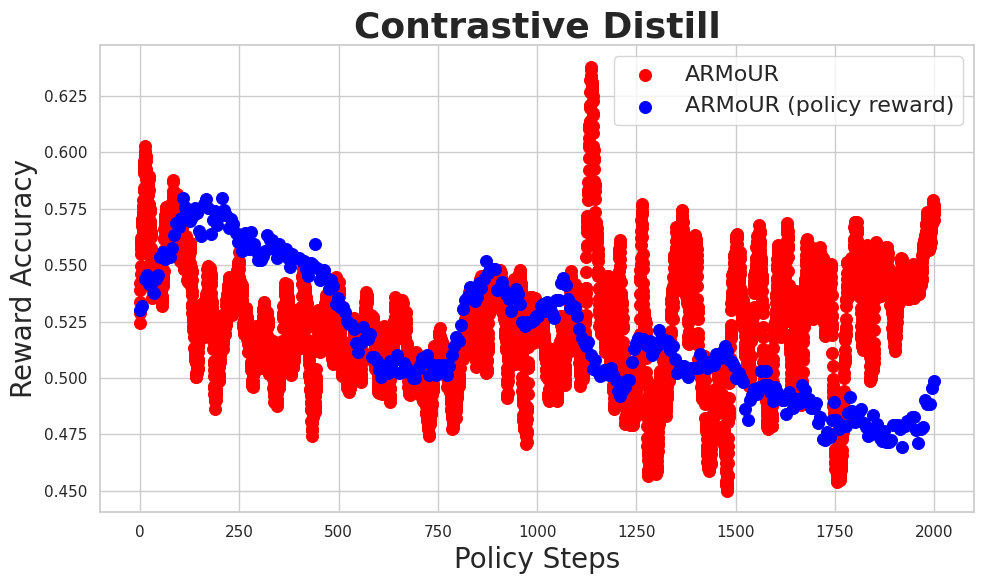

In [268]:
pdict = {labels[a]:(intervmean(allaccs[a], intervs[a] , windows[a]), ratios[a]) for a in range(len(approaches))}
plot_methods(pdict, xlabel="Policy Steps", ylabel="Reward Accuracy", setname="Contrastive Distill", fname="cdistpolicyacc.pdf")

<Figure size 1000x600 with 0 Axes>

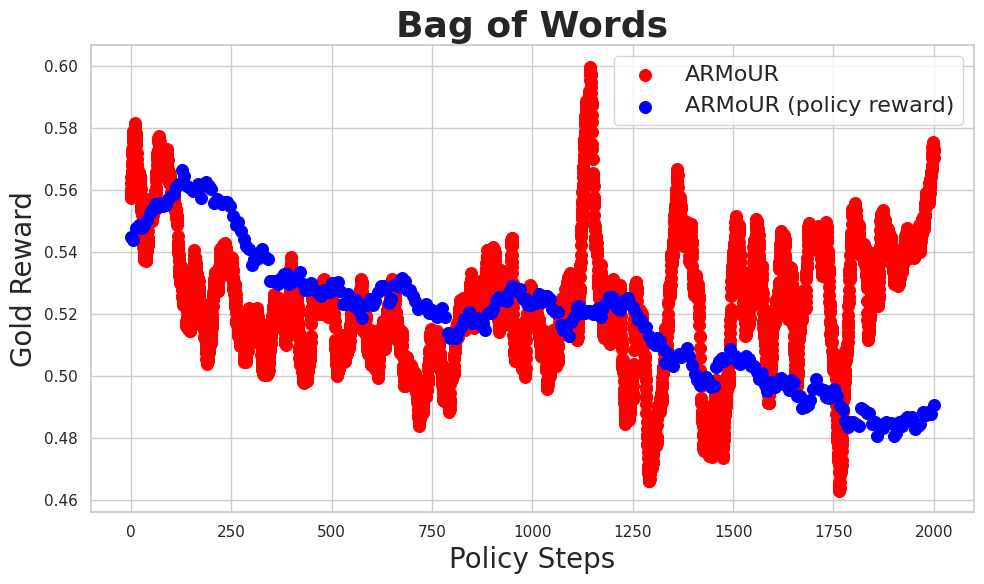

In [265]:
plot_methods(pdict, xlabel="Policy Steps", ylabel="Gold Reward", setname="Bag of Words")

In [ ]:
tmpbase = loadf(basefs[dset])
if len(tmpbase)>100000:
    tmpbase = tmpbase.iloc[64000:].reset_index()
basengs, baseaccs = makengs(tmpbase)
print("loaded base")
allmethngs = []
allmethaccs = []
# have a  list of stuff, TODO there's a better way to check this
if len(bestmethds[dset])<5:
    for d in bestmethds[dset]:
        tmpmethod = loadf(d)
        methngs, methaccs = makengs(tmpmethod)
        allmethngs.append(methngs)
        allmethaccs.append(methaccs)
        
print("loaded method")

# tlog = pd.read_json("../../active-rlhf/outputs/results/rollouts/math/ppo_goldb8easy4fix.jsonl", orient='records', lines=True, nrows=64000)
# tlog = pd.read_json("../../outputs/bagofwords/dynarmlogs/expbow50_updatereprod_fix.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../../activereprod/active-rlhf/outputs/results/dynarmlogs/math/u/prasanns/research/active-rlhf/outputs/models/math/tiny_rm_rand_subsamp_onlymathreprod3.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../outputs/results/dynarmlogs/.jsonl", orient='records', lines=True)

In [5]:
tlog = pd.read_json("../../active-rlhf/outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed3.jsonl", orient='records', lines=True, nrows=64000)


In [6]:
tlog

,texts,rewards,golds,call
0,[Question: How has the fashion industry change...,"[5.0, 5.40625]","[7.0, 4.0]","[1, 1]"
1,[Question: What is the importance of seeking p...,"[5.625, 4.21875]","[5.0, 3.0]","[1, 1]"
2,[Question: Could you recommend some effective ...,"[4.75, 4.34375]","[6.0, 5.0]","[1, 1]"
3,[Question: Place the hay bales in Harvey’s roo...,"[3.421875, 5.34375]","[3.0, 2.0]","[1, 1]"
4,[Question: How is the automotive industry util...,"[4.875, 4.125]","[8.0, 4.0]","[1, 1]"
...,...,...,...,...
63995,[Question: How do interconnected systems and v...,"[-1.609375, 5.28125]","[12.0, 20.0]","[4000, 4000]"
63996,[Question: How do organic and conventional far...,"[6.6875, -2.84375]","[20.0, 14.0]","[4000, 4000]"
63997,[Question: Write a detailed and practical inst...,"[9.0, 8.875]","[20.0, 20.0]","[4000, 4000]"
63998,[Question: Write a 1000-word feature article o...,"[6.9375, 7.09375]","[19.0, 20.0]","[4000, 4000]"


In [35]:
ngsdict = {
    'PPO(50K RM)': (basemeans, 2), 
    'Online DPO (Gold)': (methmeans, 2), 
    ""
}
accsdict = {
    'PPO(50K RM)': (basemeans, 2), 
    'Online DPO (Gold)': (methacms, 2), 
}

In [61]:
# ngsdict['ARMoUR'] = ngsdict['Online DPO (Gold)']
# accsdict['ARMoUR'] = accsdict['Online DPO (Gold)']
accsdict['Online DPO (Gold)'] = (baseacms, 8)
ngsdict['Online DPO (Gold)'] = (basemeans, 8)


In [52]:
ngsdict['ARMoUR'] = (ngsdict['ARMoUR'] , 2)
ngsdict['Online DPO (Gold)'] = (ngsdict['Online DPO (Gold)'] , 8)

In [70]:
del accsdict['Online DPO (Gold)']

In [57]:
ngsdict['ARMoUR'] = ngsdict['ARMoUR'][0]

In [21]:
tgolds = []
for _, row in tqdm(tmpbase.iterrows()):
    
    tgolds.append(get_synth_rewards([qaform(row['inputs'][i], row['outputs'][i]) for i in range(len(row['inputs']))], 'bagofwords') )

1400it [00:11, 118.66it/s]


In [24]:
tmpbase['golds'] = tgolds

In [12]:
tmpbase

,texts,rewards,golds,call
0,[Below is an instruction that describes a task...,"[0.0, -16.0]","[-0.125, 0.0625]","[1, 1]"
1,[Below is an instruction that describes a task...,"[8.0, 4.0]","[-0.0625, 0.046875]","[1, 1]"
2,[Below is an instruction that describes a task...,"[12.0, 8.0]","[0.21875000000000003, 0.15625]","[1, 1]"
3,[Below is an instruction that describes a task...,"[-9.0, 2.0]","[0.234375, 0.03125]","[1, 1]"
4,[Below is an instruction that describes a task...,"[2.0, 4.0]","[0.109375, -0.0625]","[1, 1]"
...,...,...,...,...
128475,[Below is an instruction that describes a task...,"[-26.0, -26.0]","[0.875, 0.875]","[4000, 4000]"
128476,[Below is an instruction that describes a task...,"[-35.0, -35.0]","[0.375, 0.375]","[4000, 4000]"
128477,[Below is an instruction that describes a task...,"[-25.0, -6.0]","[0.640625, 0.640625]","[4000, 4000]"
128478,[Below is an instruction that describes a task...,"[-27.0, -5.0]","[0.5625, 0.5625]","[4000, 4000]"


In [7]:
baseratio = 8

In [ ]:
basengs, baseaccs = makengs(newtest)
methngs, methaccs = makengs(tmpdynarmlogs)

In [9]:
allmethngs = []

In [22]:


basemeans = intervmean([mean(m) for m in basengs], 25, 50)
if len(allmethngs)>0:
    methmeans = intervmean(combineall(allmethngs), 25 , 50)
else:
    methmeans = intervmean([mean(m) for m in methngs], 25 , 50)
baseacms = intervmean(baseaccs, 25, 250)
methacms = intervmean(methaccs, 25 , 250)

In [23]:
mean(methmeans[-20:-10])

0.4824557291666667

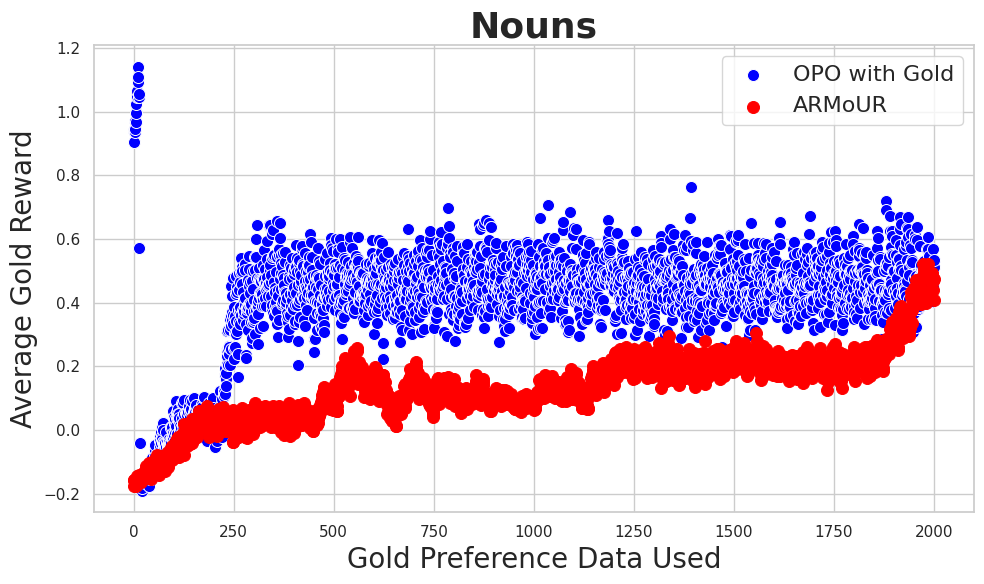

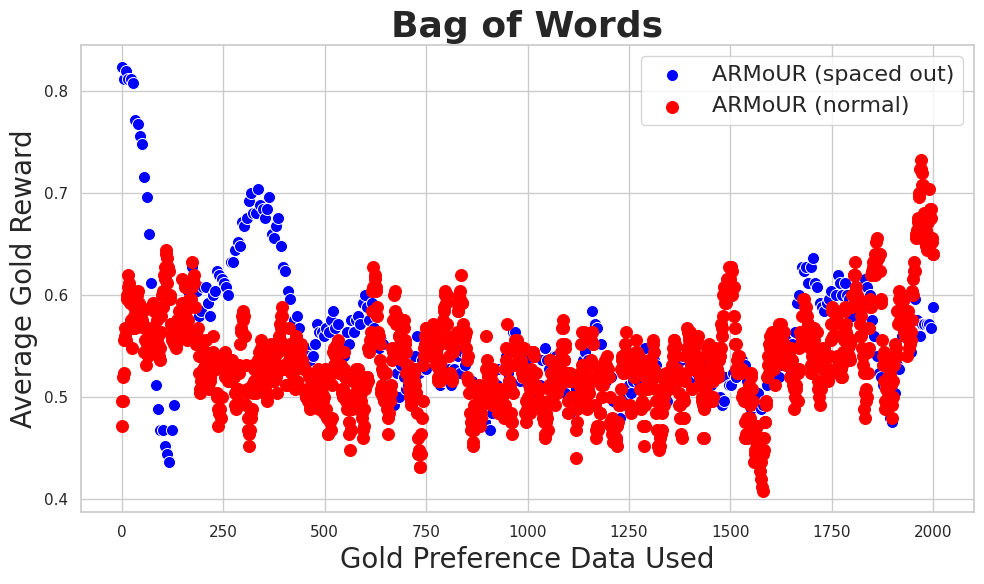

In [24]:
fig = ratio_scatter(basemeans, methmeans, 2000, mratios[dset], mratios[dset], "efficientplots/"+dset+".pdf", "Nouns")
# fig = ratio_scatter(basemeans, basemeans, 2000, baseratio, baseratio, "efficientplots/tmp"+".pdf", "tmp")

fig = ratio_scatter(baseacms, methacms, 2000, mratios[dset], mratios[dset], "efficientplots/acc"+dset+".pdf", "Bag of Words", methmax=False, labels=['ARMoUR (spaced out)', 'ARMoUR (normal)'])

In [30]:
def splitter(inp):
    # qa style
    if ("Question:" in inp) and "Answer:" in inp: 
        instruction, response = inp.split("\n\nAnswer: ")
        instruction = instruction[len("Question: "):]
    # alpacafarm style
    if "### Instruction:" in inp:
        instruction_match = re.search(r'### Instruction:\n(.*?)(### Response:|\Z)', inp, re.DOTALL)
        instruction = instruction_match.group(1).strip() if instruction_match else inp
        # Extract Response
        response_match = re.search(r'### Response:.*?(.*?)(### |\Z)', inp, re.DOTALL)
        response = response_match.group(1).strip() if response_match else ""
    # tulu style
    if "<user>" in inp: 
        q = inp[len("<user>\n"):]
        instruction, response = q.split("\n<assistant>\n")
    
    return instruction, response
# given a starting index (default 0), and some other thing, return the
# better and worse index in that order
def indcomp(rws, sind=0, eind=-1): 
    # extra functionalty
    if eind>=0: 
        return (sind, eind) if rws[sind]>rws[eind] else (eind, sind)
    if rws[0]>rws[1]:
        return 0+sind, 1+sind
    return 1+sind, 0+sind
    
# given a dataframe with a "golds" column, make rollouts into preference data (assume that pairs go together as rollouts)
def dynarm_to_prefs(indf):
    prefdata = []
    for ind, row in indf.iterrows():
        inp = splitter(row['texts'][0])[0]
        resps = [splitter(row['texts'][i])[1] for i in range(2)]
        indj, indk = indcomp(row['golds'], 0)
        tmp = {
            'question': inp,
            'response_j': resps[indj],
            'response_k': resps[indk],
            'score_j': row['golds'][indj], 
            'score_k': row['golds'][indk],
            'magnitude': row['golds'][indj] - row['golds'][indk]
        }
        prefdata.append(tmp)
            
    return Dataset.from_list(prefdata)
    
# get a training set or eval set from some input
def interv_setup(indata, amt=5, start=0, end=(1/16)):
    # Create a mask to identify rows where the two numbers in each list are identical
    mask = indata['golds'].apply(lambda x: x[0] != x[1])
    
    # Filter out rows where numbers are identical
    filtered_df = indata[mask]
    
    # based on old index, not the new thing
    subset = filtered_df.loc[int(len(indata)*start):int(len(indata)*end)]
    return subset.sample(amt)


In [ ]:
for i in range(0, 5):
    t = interv_setup(tmpmethod, 5)
    p = dynarm_to_prefs(t)
    print(p[0])
    #p.save_to_disk("../outputs/data/"+dset+"/5set"+str(i))

for i in range(0, 5):
    t = interv_setup(tmpmethod, 50)
    p = dynarm_to_prefs(t)
    print(p[0])
    #p.save_to_disk("../outputs/data/"+dset+"/50set"+str(i))

In [109]:
t = interv_setup(tmpmethod, 200, (1/16), (2/16))
p = dynarm_to_prefs(t)
print(p[0])
p.save_to_disk("../outputs/data/"+dset+"/latereval")

t = interv_setup(tmpmethod, 200, (0), (1/16))
p = dynarm_to_prefs(t)
print(p[0])
p.save_to_disk("../outputs/data/"+dset+"/earlyeval")

{'question': 'Write a formal letter of request to a supplier requesting them to arrange a product demonstration at your workplace, highlighting the specific product features that you want to be demonstrated and providing the suggested dates and times for the demonstration.', 'response_j': "\n' New / New / American | Restaurant | LampBot | Catering | Biotechnology | Grade Code this class are: Crown Coffee / Ace Okong / Olive Oil /: Lemonhead /: Keurjuic /: Lucent", 'response_k': '\n\n• Architect, Requirements; Client ("Automation software), Software Developer (AMS), ILM, PrettyBox, Applied Water Optics (NASNAS, JPEGO, etc.), (hardware, electronics, telecom, entertainment', 'score_j': 27.0, 'score_k': 20.0, 'magnitude': 7.0}


{'question': 'Which surfacing materials are suitable for the Play Mound and Tunnel and how do they enable year-round use?: This durable Play Mound and Tunnel offers hours of fun from the crawl through tunnel to the large play mound and lookout points. It supports the understanding of positional language, as children can go under, over, around, be above, below and look through the windows. Its also great for inspiring imaginative and creative play.\nCombined with your choice of surfacing, ranging from synthetic grass, wet pour safety surfacing or rubber bark, it provides all year round use. Great as an addition to any adventure play space or as an imaginative transition between outside zones.', 'response_j': '\nWhile the Play Mound and Tunnel is a linear, non-stone-like structure, which supports the play mound and the tuning wheel, it is excellent for play structures such as fence, pegback, and stair slides. Just as you', 'response_k': '\nThe Play Mound and Tunnel all lend a splash of h

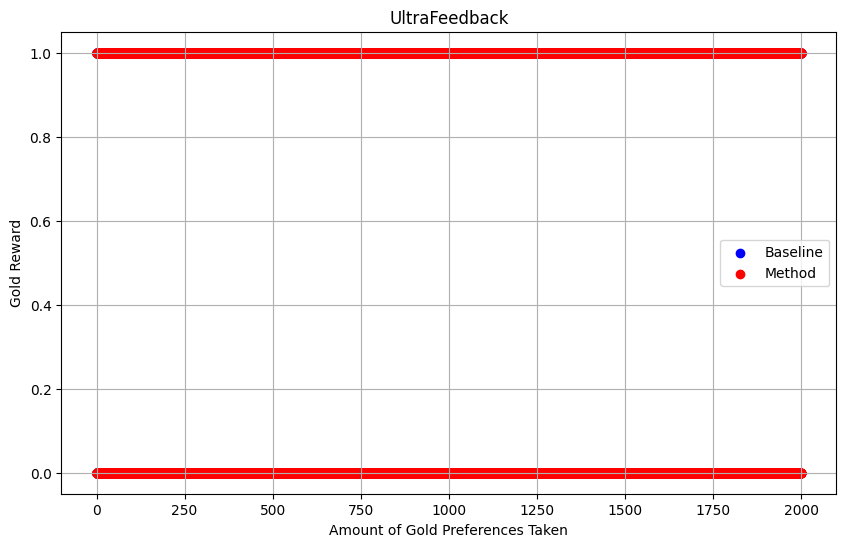

In [104]:
fig = ratio_scatter(baseaccs, methaccs, 2000, mratios[dset], mratios[dset], "efficientplots/"+dset+".pdf", "UltraFeedback")

In [6]:
tmpb = loadf("../outputs/results/rollouts/bagofwords/ppo_conf_newalgo_5testlogrun.jsonl")
tmpdynarmlogs = loadf("../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testlogrun.jsonl")

4000


In [22]:
tmpb = loadf("../outputs/results/rollouts/contrastivedistill/ppo_rand_cdist_10_5_logrun.jsonl")
tmpdynarmlogs = loadf("../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_logrun.jsonl")

4000
64000


In [23]:
def newpairdf(tmpdf, rws, fdim=2):
    newdf = tmpdf.copy()
    tot = []
    for r in rws: 
        tot.extend(r)
    newv = []
    for i in range(0, len(tot), fdim):
        newv.append(tot[i:i+fdim])
    mval = min(len(newv), len(newdf))
    print(mval)
    print(len(newdf))
    newdf['rewards'][:min(len(newv), len(newdf))] = newv[:min(len(newv), len(newdf))]
    
    return newdf

newtest = newpairdf(tmpdynarmlogs, tmpb['selfscos'])

64000
64000


In [10]:
len(tmpb['selfscos'][0])

32

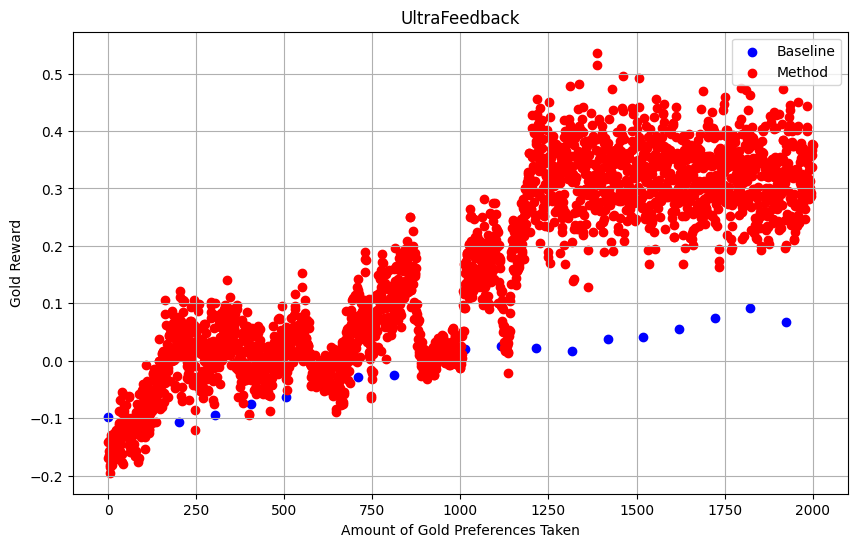

In [19]:
fig = ratio_scatter(basemeans, methmeans, 2000, baseratio, mratios[dset], "efficientplots/"+dset+".pdf", "UltraFeedback")

In [36]:
ngs, accs = makengs(tmp)

0.049515625


In [40]:
meanngs = list([mean(n) for n in ngs])

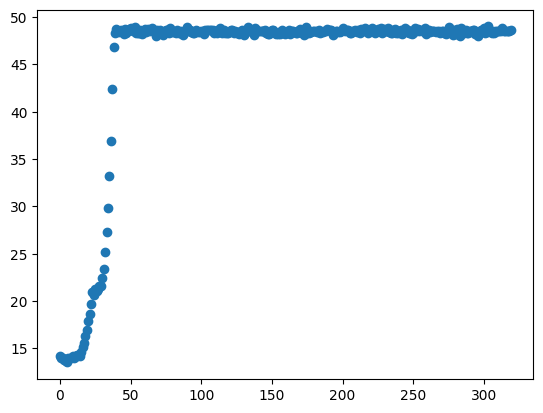

In [42]:
accscatter(meanngs)

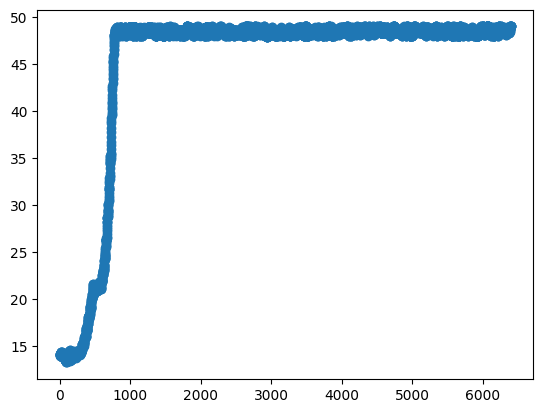

In [15]:
means = [mean(m) for m in ngs]
# means = [mean(m) for m in tmp['rewards']]

interv = 10
mbins = [mean(means[i:i+100]) for i in range(0, len(means), interv)]
plt.scatter(range(len(mbins)), mbins)

In [55]:
print(max(mbins))
print(mean(mbins[-100:]))

49.0
48.5851


In [194]:
tmp.iloc[1000:1010]

,texts,rewards,golds,call
1000,[Question: (((8 * 6) * 2) + 9) = \n\nAnswer: ...,"[-0.23632812500000003, -0.33984375]","[2.619047619047619, 2.611111111111111]","[63, 63]"
1001,[Question: (((2 * 9) * 4) - 2) = \n\nAnswer: ...,"[-0.2353515625, -0.2412109375]","[3.174603174603174, 3.611111111111111]","[63, 63]"
1002,[Question: (((7 * 8) - 4) - 8) = \n\nAnswer: ...,"[-0.208984375, -0.2314453125]","[2.444444444444444, 2.0]","[63, 63]"
1003,[Question: (((4 * 9) - (2 - 7)) - 2) = \n\nAns...,"[0.125, 0.12304687500000001]","[2.70021645021645, 1.7568779904306222]","[63, 63]"
1004,[Question: (((3 * 5) - 1) + 8) = \n\nAnswer: ...,"[-0.2470703125, -0.27734375]","[3.055555555555556, 2.166666666666667]","[63, 63]"
1005,[Question: (((9 * 3) * 5) + (4 * 3)) = \n\nAns...,"[-0.255859375, -0.259765625]","[3.178436147186147, 2.76176948051948]","[63, 63]"
1006,[Question: (((8 * 2) * 2) - 7) = \n\nAnswer: r...,"[-0.039306640625, -0.279296875]","[2.111111111111111, 2.444444444444444]","[63, 63]"
1007,[Question: (((1 * 4) * 1) * 4) = \n\nAnswer: ...,"[-0.1142578125, -0.2734375]","[4.166666666666667, 3.092592592592593]","[63, 63]"
1008,[Question: (((1 * 3) + 6) - 2) = \n\nAnswer: ...,"[-0.373046875, -0.251953125]","[2.777777777777777, 5.0]","[64, 64]"
1009,[Question: (((4 - 2) - 9) + (2 + 9)) = \n\nAns...,"[0.0137939453125, -0.23828125]","[2.285714285714286, 2.957417582417582]","[64, 64]"


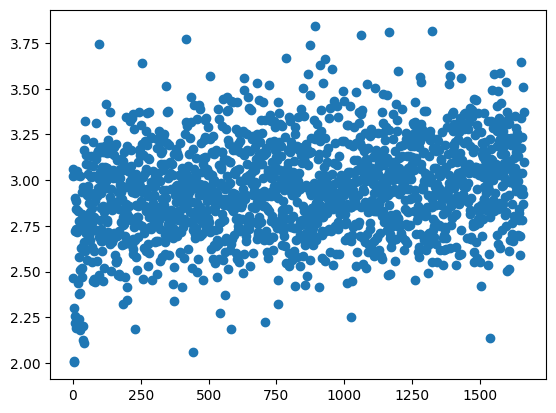

In [50]:
means = [mean(m) for m in tmp['golds']]
plt.scatter(range(len(means)), means)

In [14]:
from os import listdir
import json

In [15]:
def makeplot(base, key, start=100, end=2000, gap=100):
    mvs = []
    cks = []
    for s in range(start, end+1, gap):
        #print(s)
        fname = base+"/"+key+str(s)+".results"
        # print(fname)
        with open(fname, "r") as f:
            res = json.load(f)
            #print(res)
            mv = mean([m[0] for m in res['truncval']])
            cks.append(s)
            mvs.append(mv)
    return mvs# , cks

In [40]:
keys = ['ppo_conf_newalgo_5testnewseed3', 'ppo_conf_newalgo_goldb8_1ups', 'ppo_confbow_goldb8_selfreward', "ppo_conf_newalgo_5testnewseed2_dpoapi"]
bowmainres = {
    'D2PO':(1, [4.9, 6.520833333333333, 6.84375, 7.604166666666667, 9.145833333333334, 11.114583333333334, 11.71875, 12.458333333333334, 12.65625, 13.5625, 14.4375, 14.5625, 15.083333333333334, 15.65625, 15.697916666666666, 15.90625, 16.854166666666668, 17.479166666666668, 17.90625, 18.25, 19.604166666666668]), 
    'OPO w/ gold':(1, [4.9,8.0, 8.552083333333334, 9.854166666666666, 11.291666666666666, 11.09375, 11.8125, 13.15625, 12.635416666666666, 13.572916666666666, 14.510416666666666, 14.5, 14.6875, 14.510416666666666, 14.510416666666668, 15.15625, 15.958333333333332, 15.572916666666668, 16.635416666666668, 15.989583333333334, 16.479166666666668])
}

bowextrares = {
    'D2PO RM':(1, [4.9, 6.520833333333333, 6.84375, 7.604166666666667, 9.145833333333334, 11.114583333333334, 11.71875, 12.458333333333334, 12.65625, 13.5625, 14.4375, 14.5625, 15.083333333333334, 15.65625, 15.697916666666666, 15.90625, 16.854166666666668, 17.479166666666668, 17.90625, 18.25, 19.604166666666668]), 
    'D2PO DPO':(1, [4.9, 6.833333333333333, 8.791666666666666, 11.083333333333334, 11.75, 11.552083333333334, 12.395833333333334, 12.927083333333334, 12.895833333333334, 13.583333333333334, 14.395833333333334, 14.5625, 14.739583333333334, 15.302083333333334, 15.572916666666666, 15.40625, 15.291666666666666, 15.229166666666666, 15.875, 15.822916666666666, 16.677083333333332]),
    'D2PO self-reward':(1, [4.9, 7.5625, 9.322916666666666, 10.15625, 11.40625, 12.0, 12.552083333333334, 12.65625, 12.885416666666666, 12.791666666666666, 13.46875, 13.791666666666666, 14.28125, 14.354166666666666, 14.645833333333334, 14.447916666666666, 14.604166666666666, 14.822916666666666, 14.760416666666666, 14.729166666666666, 14.885416666666666])
}
# TODO verify
bowmainpoints = [(800, 6.2), (800,5)]

nounmainres = {
    'D2PO':(0.4, [12, 12.395833333333334, 13.78125, 16.09375, 32.3, 46.833333333333336, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875]),
    'OPO w/ gold':(0.8, [12, 13.5, 19.552083333333332, 34, 43.78125, 45, 47.177083333333336, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.177083333333336, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875])
}
# TODO verify
nounmainpoints = [(800, 14), (800,24)]


<Figure size 1000x600 with 0 Axes>

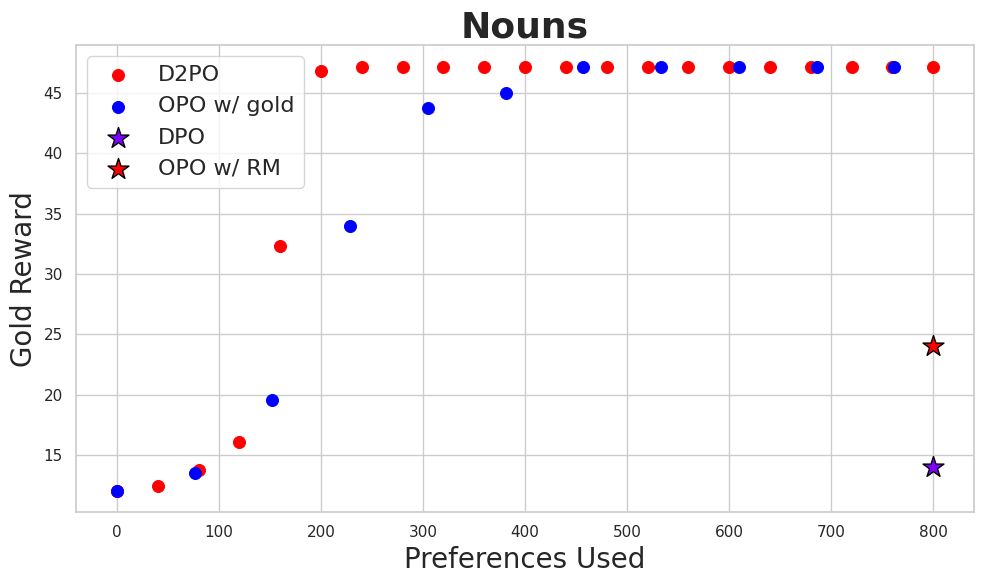

In [44]:
plot_methods(nounmainres, xlabel="Preferences Used", ylabel="Gold Reward", setname="Nouns", fname ='nounmain.pdf', point_labels=['DPO', "OPO w/ RM"], points=[(800, 14), (800,24)])

In [30]:
# makeplot("../outputs/results/genouts/bagofwords", "ppo_conf_newalgo_goldb8_1ups", 25, 500, 25)
keys = ["ppo_confnoun_newalgo_2_5_seed3", "ppo_confnoun_goldb8_4ups"]
print(makeplot("../outputs/results/genouts/nouns", keys[1], 25, 250, 25))

[19.552083333333332, 43.78125, 47.177083333333336, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875]


In [22]:
listdir("../outputs/results/genouts/nouns")

['ppo_justoffpolicy_confnoun_goldb8100.jsonl',
 'ppo_justoffpolicy_confnoun_goldb8100.results',
 'ppo_justoffpolicy_confnoun_goldb8500.jsonl',
 'ppo_justoffpolicy_confnoun_goldb8500.results',
 'ppo_justoffpolicy_confnoun_goldb81000.jsonl',
 'ppo_justoffpolicy_confnoun_goldb81000.results',
 'ppo_justoffpolicy_confnoun_goldb81500.jsonl',
 'ppo_justoffpolicy_confnoun_goldb81500.results',
 'ppo_justoffpolicy_confnoun_newalgo_5_2100.jsonl',
 'ppo_justoffpolicy_confnoun_newalgo_5_2100.results',
 'ppo_justoffpolicy_confnoun_newalgo_5_2500.jsonl',
 'ppo_justoffpolicy_confnoun_newalgo_5_2500.results',
 'ppo_noun_initrmbaseline100.jsonl',
 'ppo_noun_initrmbaseline100.results',
 'ppo_noun_initrmbaseline500.jsonl',
 'ppo_noun_initrmbaseline500.results',
 'ppo_noun_initrmbaseline1000.jsonl',
 'ppo_noun_initrmbaseline1000.results',
 'ppo_noun_initrmbaseline1500.jsonl',
 'ppo_noun_initrmbaseline1500.results',
 'nouns20k_20kdpo_dpo1000.jsonl',
 'nouns20k_20kdpo_dpo1000.results',
 'nouns20k_20kdpo_dpo2

In [ ]:
makeplot("../outputs/results/genouts/bagofwords", "ppo_conf_newalgo_goldb8_1ups", 25, 500, 25)